# Pathfinding Exploration

- DFS
- BFS
- IDDFS (removed completely)
- A-star

In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output, display

from utils.search import bfs, dfs, dfs_heuristic, greedy_bfs, a_star
from utils.graph import Graph
from utils.plots import plot_grid, plot_path

## A simple example of N = 1

Also showing the different types of grids that can be used.

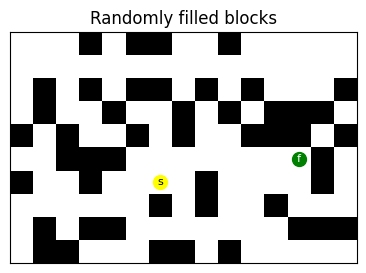

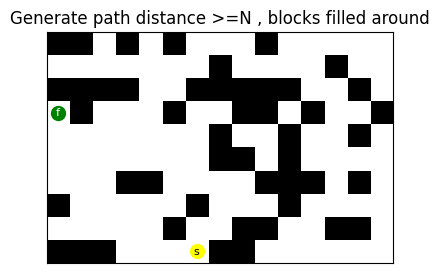

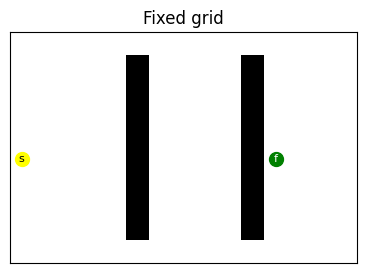

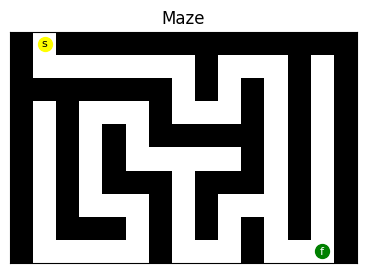

In [2]:
percent_blockage = 0.4

graph = Graph(rows=10, cols=15)


graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Randomly filled blocks")
plt.show()

graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Generate path distance >=N , blocks filled around")
plt.show()

graph.generate_grid(grid_type="fixed", variant=2)
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Fixed grid")
plt.show()

graph.generate_grid(grid_type="maze")
plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.title("Maze")
plt.show()

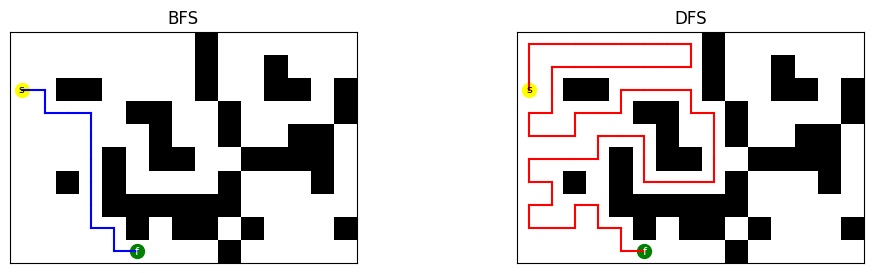

BFS:
Time: 0.0001900196075439453 (s)
# Iteractions: 64
Path length: 12

DFS:
Time: 0.0001380443572998047 (s)
# Iteractions: 73
Path length: 58


In [3]:
graph.generate_grid(grid_type="random-1", percent_blocked=percent_blockage)

bfs_path, bfs_complexity = graph.search(bfs)
dfs_path, dfs_complexity = graph.search(dfs)

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], dfs_path, c='red',label='DFS')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

### Let's see this interactively

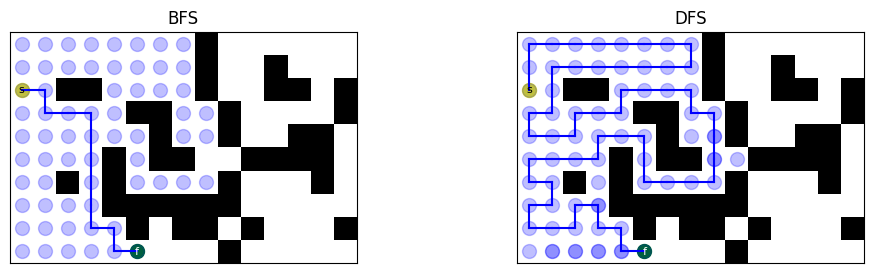

In [4]:
bfs_generator = graph.search_generator(bfs)
dfs_generator = graph.search_generator(dfs)

generators = [bfs_generator, dfs_generator]

_, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("DFS")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

## Let's do this many times and compare.

Important to note that as the `percent_blockage` gets to a certain point, there tends to become less and less available paths (and neighbors), so we see some convergence between methods. I'll stop it by a certain point, as we're guaranteeing an existing path, so going beyond a certain `percent_blockage` becomes redundant.

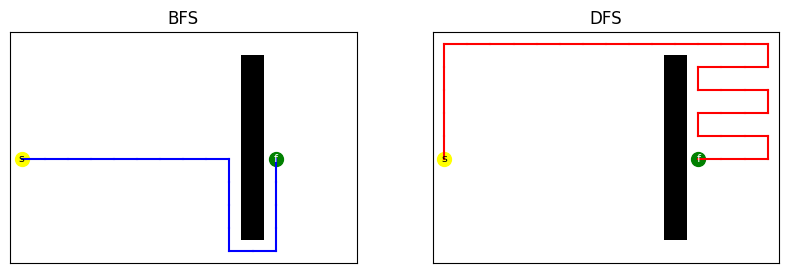

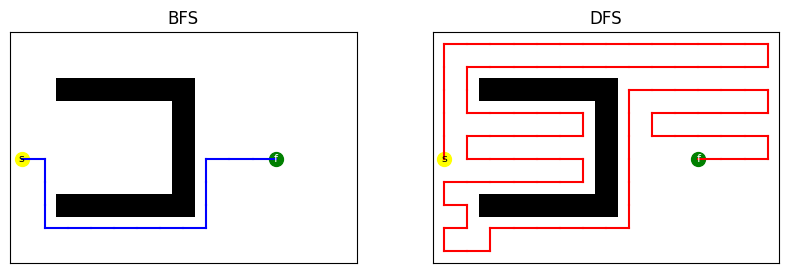

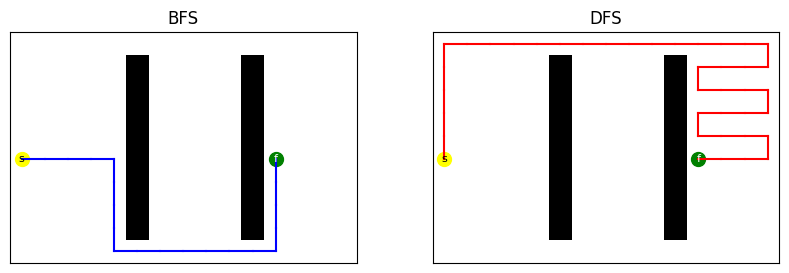

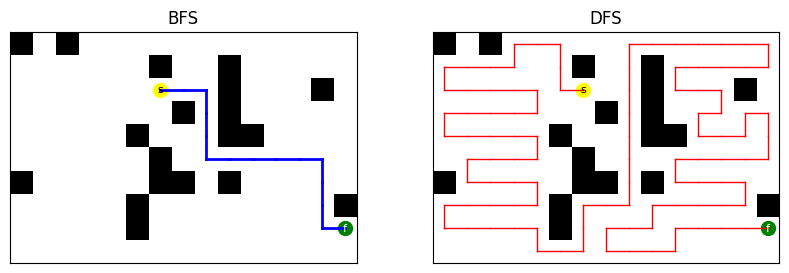

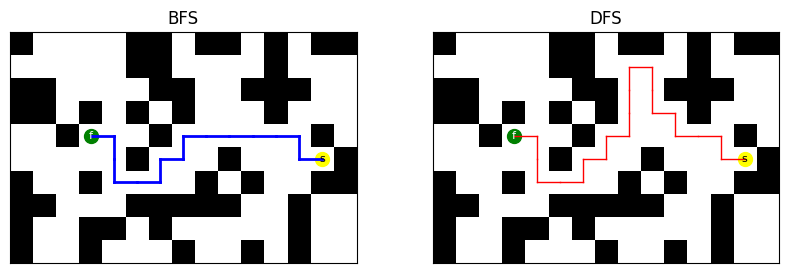

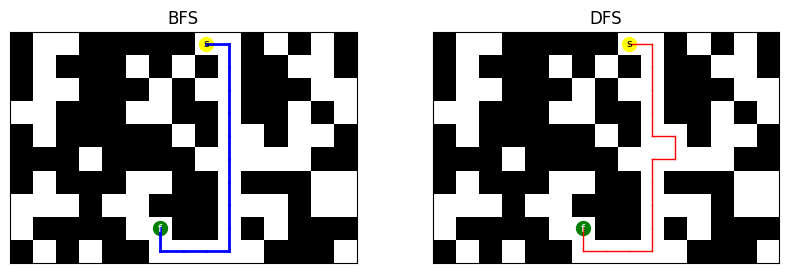

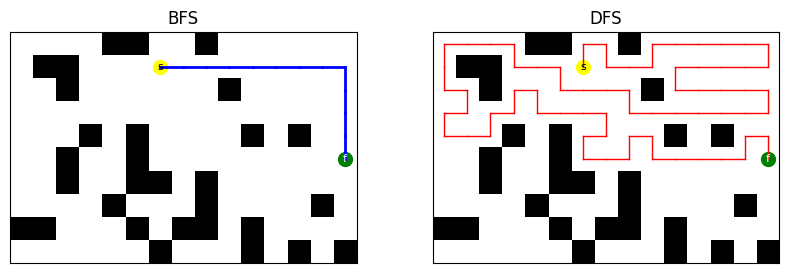

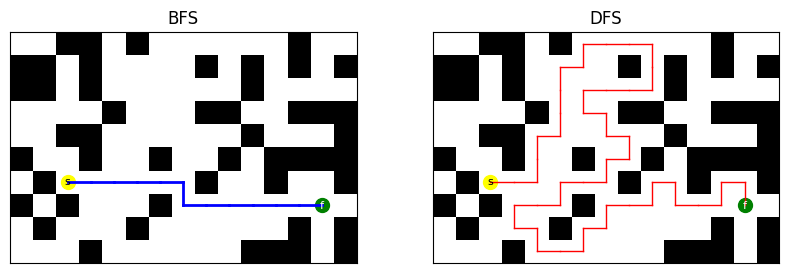

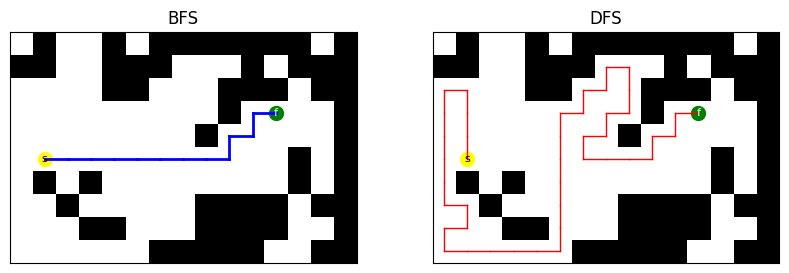

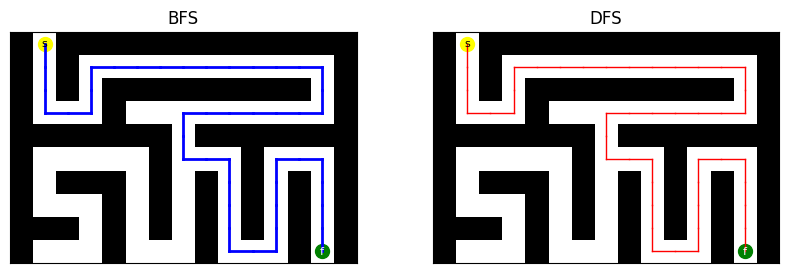

In [35]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs": {"time": 0, "iterations": 0, "length": 0},
    }
    graph.generate_grid(grid_type="fixed", variant=variant)
    bfs_path, bfs_complexity = graph.search(bfs)
    dfs_path, dfs_complexity = graph.search(dfs)

    data["bfs"]["time"] = bfs_complexity["time"]
    data["bfs"]["iterations"] = bfs_complexity["iterations"]
    data["bfs"]["length"] = bfs_complexity["length"]

    data["dfs"]["time"] = dfs_complexity["time"]
    data["dfs"]["iterations"] = dfs_complexity["iterations"]
    data["dfs"]["length"] = dfs_complexity["length"]

    _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], dfs_path, c='red',label='DFS')

    plt.show()

    datas.append(data)

# Random grids with varying percent blockages
for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": "random",
            "bfs": {"time": 0, "iterations": 0, "length": 0},
            "dfs": {"time": 0, "iterations": 0, "length": 0},
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)
            bfs_path, bfs_complexity = graph.search(bfs)
            dfs_path, dfs_complexity = graph.search(dfs)

            data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
            data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
            data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

            data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
            data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
            data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)
        
        _, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
        plot_path(axes[0], bfs_path, c='blue',label='BFS', linewidth=2)
        plot_path(axes[1], dfs_path, c='red',label='DFS', linewidth=1)

        plt.show()

        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
    "bfs": {"time": 0, "iterations": 0, "length": 0},
    "dfs": {"time": 0, "iterations": 0, "length": 0},
}
for i in range(n):
    graph.generate_grid(grid_type="maze")
    bfs_path, bfs_complexity = graph.search(bfs)
    dfs_path, dfs_complexity = graph.search(dfs)

    if bfs_complexity["time"] is None: continue

    data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
    data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
    data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

    data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
    data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
    data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)
_, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
plot_path(axes[0], bfs_path, c='blue',label='BFS', linewidth=2)
plot_path(axes[1], dfs_path, c='red',label='DFS', linewidth=1)

plt.show()

datas.append(data)



In [36]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for t in ["bfs", "dfs"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [37]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time           iterations                length  \
                      bfs       dfs        bfs         dfs       bfs   
percent type                                                           
0.0     fixed_0  0.000295  0.000066  123.00000   40.000000  19.00000   
        fixed_1  0.000204  0.000115  111.00000  102.000000  17.00000   
        fixed_2  0.000215  0.000051  115.00000   40.000000  19.00000   
0.2     random   0.000107  0.000084   63.11200   77.647000   9.65900   
0.4     random   0.000071  0.000063   41.68900   56.993000  12.94500   
0.6     random   0.000045  0.000033   25.46600   30.096000  14.68800   
0.2     random   0.000168  0.000092  101.51300   83.431000  12.28900   
0.4     random   0.000129  0.000079   75.51700   68.964000  12.72800   
0.6     random   0.000098  0.000055   56.56300   47.467000  13.37900   
0.0     maze     0.000082  0.000081   48.57393   72.026718  36.28678   

                            
                       dfs  
percent type                
0.0     fixed_0   39.00000  
        fixed_1  101.00000  
        fixed_2   39.00000  
0.2     random    43.28900  
0.4     random    19.96300  
0.6     random    16.17400  
0.2     random    58.71300  
0.4     random    34.42400  
0.6     random    26.48900  
0.0     maze      36.28678

# Adding heuristics to search

Right now selecting a neighbor has equivalent "cost". We know where the starting + end locations are located, so can we use this information?

Rather than BFS / DFS randomly traversing the space, let's intro some heuristics.

Doing this will also introduce a new Data Structure `Priority Queue`. Rather than simply using a queue, we can sort it based on some priority given a heuristic.

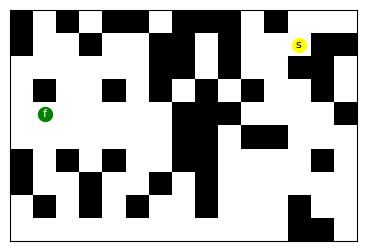

In [26]:
percent_blockage = 0.4
graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

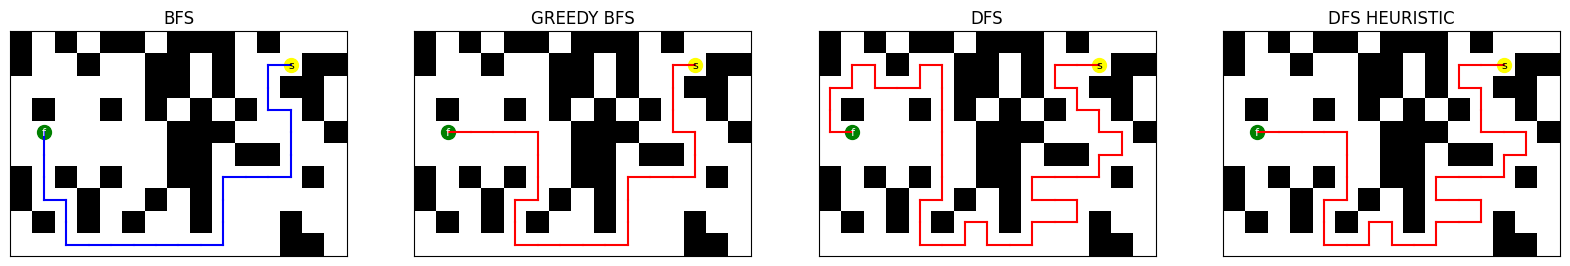

BFS:
Time: 0.00023698806762695312 (s)
# Iteractions: 75
Path length: 26

GREEDY BFS:
Time: 0.0001621246337890625 (s)
# Iteractions: 43
Path length: 28

DFS:
Time: 0.0001537799835205078 (s)
# Iteractions: 83
Path length: 48

DFS HEURISTIC:
Time: 0.00018215179443359375 (s)
# Iteractions: 63
Path length: 38


In [27]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
dfs_path, dfs_complexity = graph.search(dfs)
dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)


_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], dfs_path, c='red',label='DFS')
plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

plt.show()


print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("DFS:")
print("Time:", dfs_complexity["time"], "(s)")
print("# Iteractions:", dfs_complexity["iterations"])
print("Path length:", dfs_complexity["length"])

print()
print("DFS HEURISTIC:")
print("Time:", dfs_heur_complexity["time"], "(s)")
print("# Iteractions:", dfs_heur_complexity["iterations"])
print("Path length:", dfs_heur_complexity["length"])

### Again, let's see this interactively to how the heuristic behaves

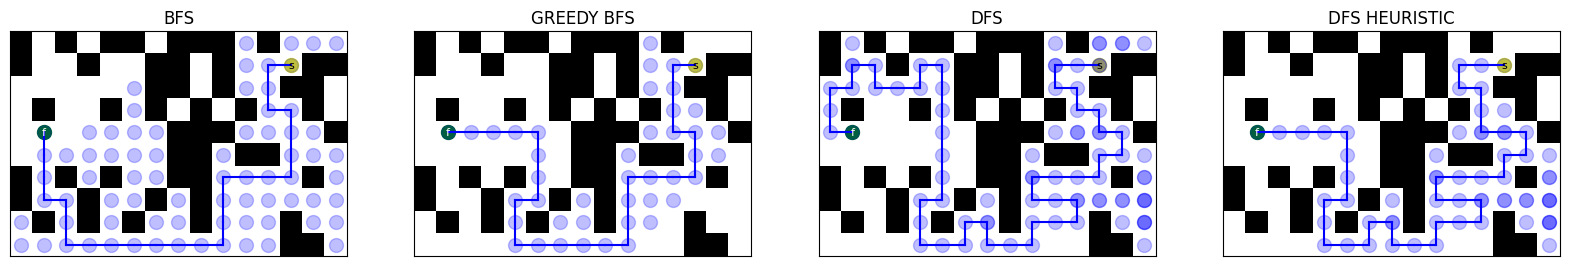

In [28]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)

generators = [bfs_generator, greedy_bfs_generator, dfs_generator, dfs_heur_generator]

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("DFS")
    axes[3].set_title("DFS HEURISTIC")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

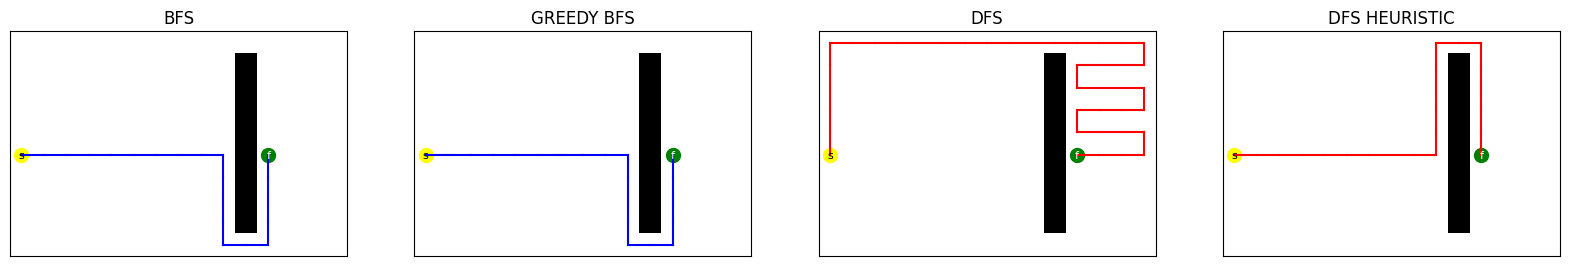

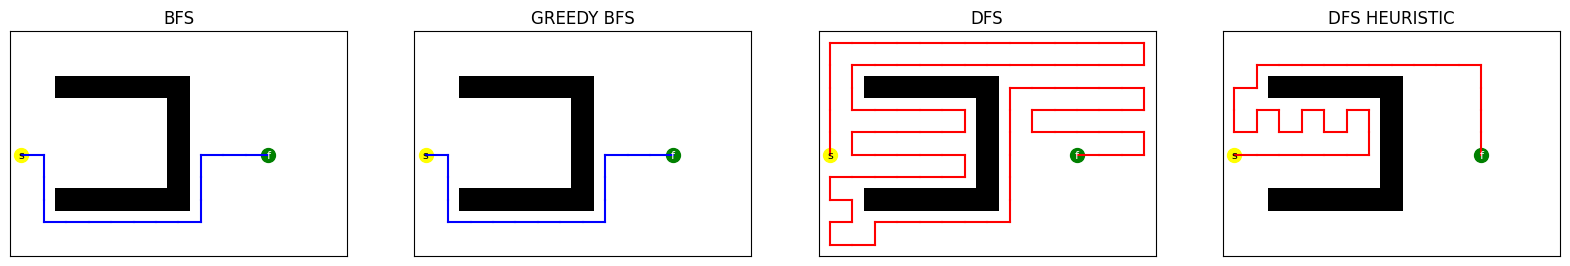

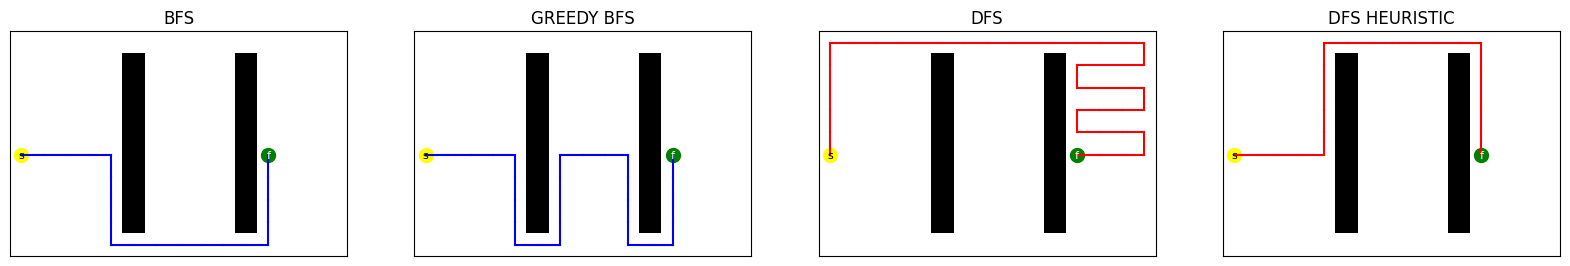

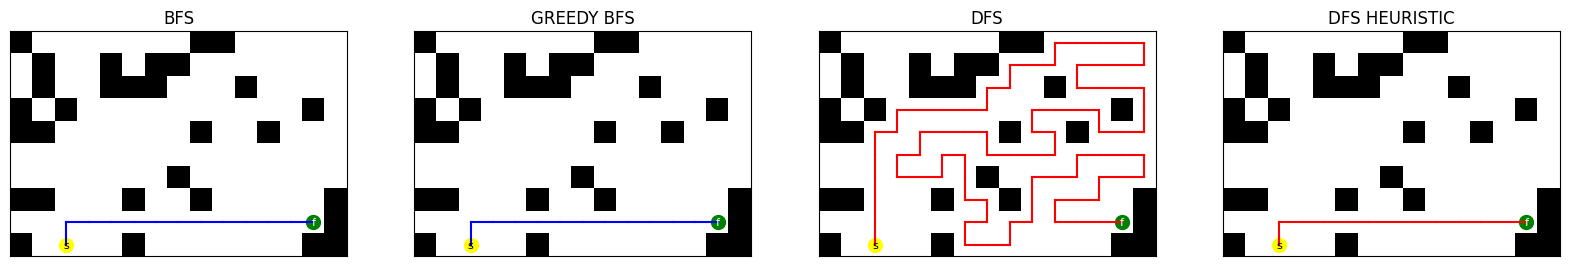

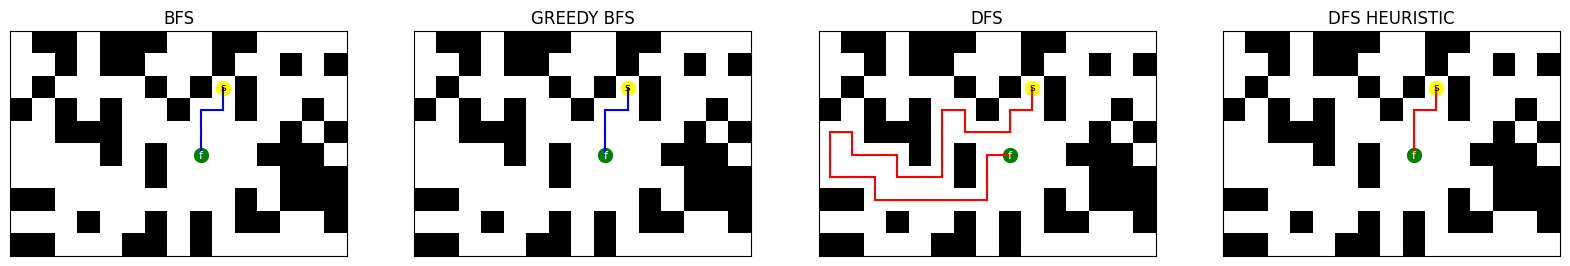

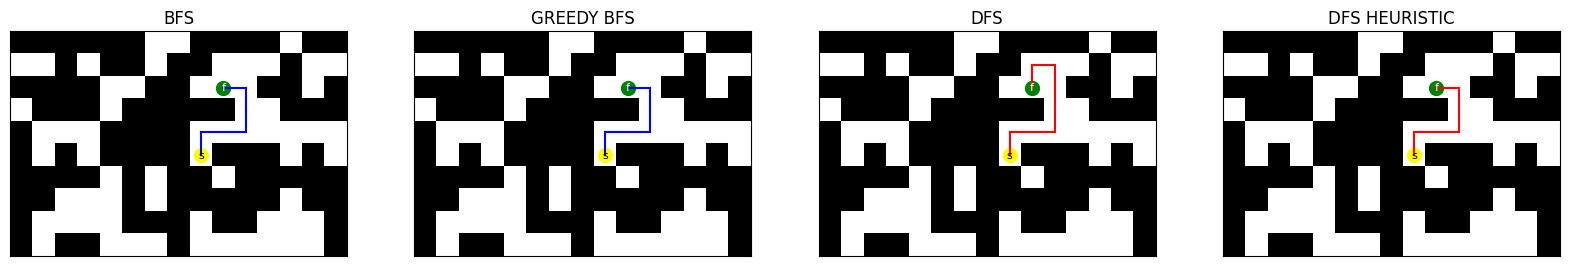

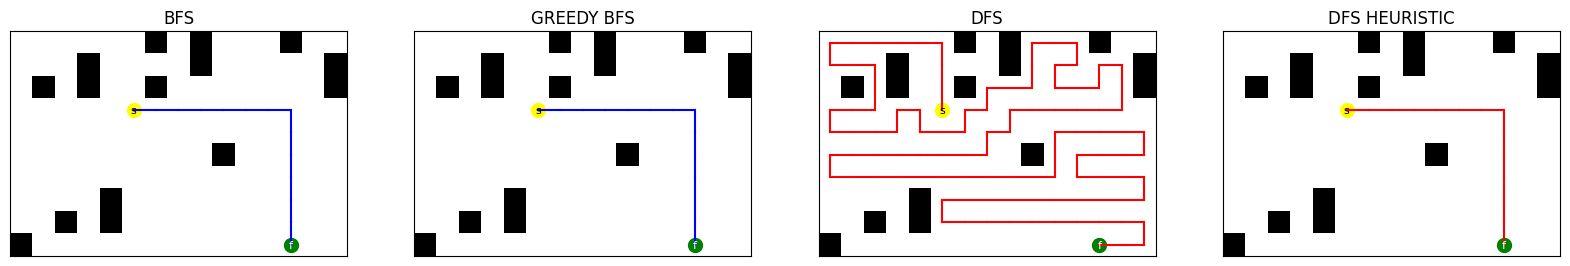

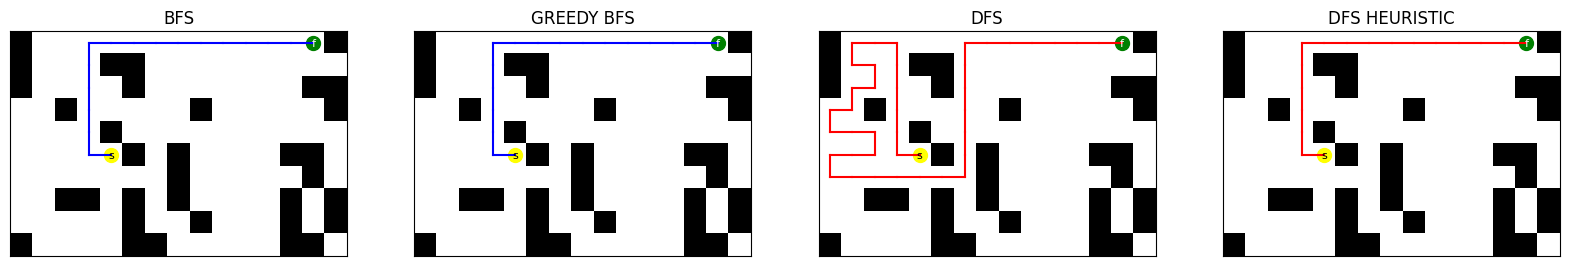

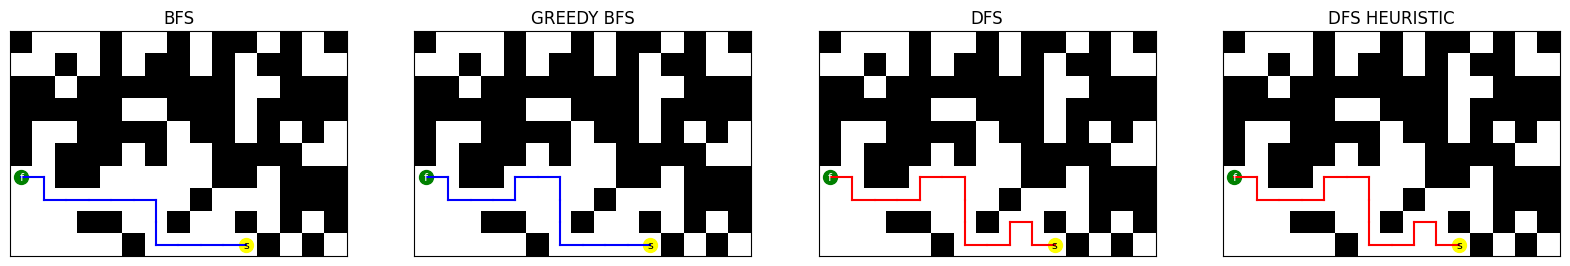

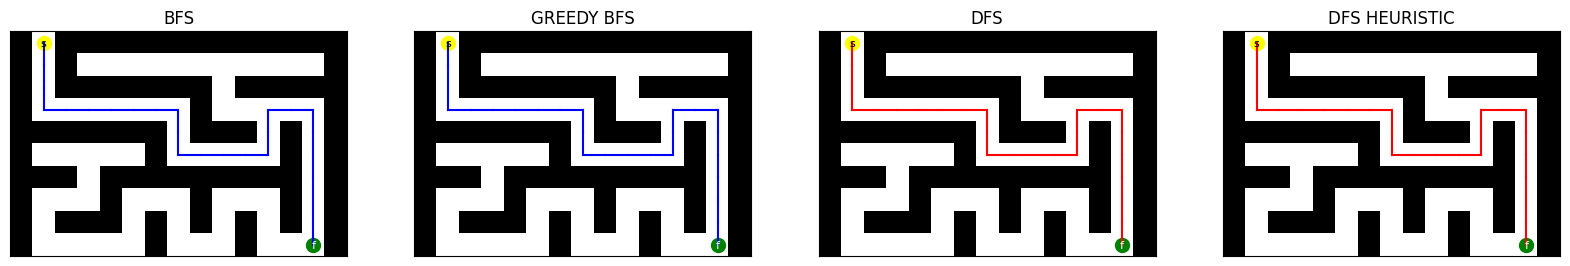

In [32]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
    }
    graph.generate_grid(grid_type="fixed", variant=variant)

    bfs_path, bfs_complexity = graph.search(bfs)
    greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
    dfs_path, dfs_complexity = graph.search(dfs)
    dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)


    data["bfs"]["time"] = bfs_complexity["time"]
    data["bfs"]["iterations"] = bfs_complexity["iterations"]
    data["bfs"]["length"] = bfs_complexity["length"]

    data["greedy_bfs"]["time"] = greedy_bfs_complexity["time"]
    data["greedy_bfs"]["iterations"] = greedy_bfs_complexity["iterations"]
    data["greedy_bfs"]["length"] = greedy_bfs_complexity["length"]

    data["dfs"]["time"] = dfs_complexity["time"]
    data["dfs"]["iterations"] = dfs_complexity["iterations"]
    data["dfs"]["length"] = dfs_complexity["length"]

    data["dfs_heur"]["time"] = dfs_heur_complexity["time"]
    data["dfs_heur"]["iterations"] = dfs_heur_complexity["iterations"]
    data["dfs_heur"]["length"] = dfs_heur_complexity["length"]

    _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
    plot_path(axes[2], dfs_path, c='red',label='DFS')
    plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

    plt.show()

    datas.append(data)

for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": "random",
            "bfs": {"time": 0, "iterations": 0, "length": 0},
            "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
            "dfs": {"time": 0, "iterations": 0, "length": 0},
            "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
        }
        for i in range(n):
            graph.generate_grid(grid_type=grid_type, percent_blocked=percent)

            bfs_path, bfs_complexity = graph.search(bfs)
            greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
            dfs_path, dfs_complexity = graph.search(dfs)
            dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)

            data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
            data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
            data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

            data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
            data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
            data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

            data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
            data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
            data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)

            data["dfs_heur"]["time"] = (data["dfs_heur"]["time"] * i + dfs_heur_complexity["time"]) / (i + 1)
            data["dfs_heur"]["iterations"] = (data["dfs_heur"]["iterations"] * i + dfs_heur_complexity["iterations"]) / (i + 1)
            data["dfs_heur"]["length"] = (data["dfs_heur"]["length"] * i + dfs_heur_complexity["length"]) / (i + 1)

        _, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
        plot_path(axes[0], bfs_path, c='blue',label='BFS')
        plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
        plot_path(axes[2], dfs_path, c='red',label='DFS')
        plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

        plt.show()

        datas.append(data)

# Maze grids
data = {
    "percent": 0,
    "type": "maze",
    "bfs": {"time": 0, "iterations": 0, "length": 0},
    "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
    "dfs": {"time": 0, "iterations": 0, "length": 0},
    "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    bfs_path, bfs_complexity = graph.search(bfs)
    greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
    dfs_path, dfs_complexity = graph.search(dfs)
    dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)

    if bfs_complexity["time"] is None: continue

    data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
    data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
    data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

    data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
    data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
    data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

    data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
    data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
    data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)

    data["dfs_heur"]["time"] = (data["dfs_heur"]["time"] * i + dfs_heur_complexity["time"]) / (i + 1)
    data["dfs_heur"]["iterations"] = (data["dfs_heur"]["iterations"] * i + dfs_heur_complexity["iterations"]) / (i + 1)
    data["dfs_heur"]["length"] = (data["dfs_heur"]["length"] * i + dfs_heur_complexity["length"]) / (i + 1)

_, axes = plt.subplots(ncols=4, nrows=1, figsize=(20,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
plot_path(axes[2], dfs_path, c='red',label='DFS')
plot_path(axes[3], dfs_heur_path, c='red',label='DFS HEURISTIC')

plt.show()

datas.append(data)


In [33]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for t in ["bfs", "greedy_bfs", "dfs", "dfs_heur"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [34]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                 iterations  \
                      bfs greedy_bfs       dfs  dfs_heur         bfs   
percent type                                                           
0.0     fixed_0  0.000283   0.000116  0.000061  0.000059  123.000000   
        fixed_1  0.000204   0.000104  0.000116  0.000078  111.000000   
        fixed_2  0.000212   0.000136  0.000049  0.000046  115.000000   
0.2     random   0.000108   0.000032  0.000087  0.000033   62.215000   
0.4     random   0.000073   0.000043  0.000065  0.000055   41.754000   
0.6     random   0.000047   0.000041  0.000035  0.000044   26.222000   
0.2     random   0.000169   0.000040  0.000089  0.000037  100.707000   
0.4     random   0.000131   0.000041  0.000078  0.000044   76.429000   
0.6     random   0.000097   0.000042  0.000056  0.000042   56.039000   
0.0     maze     0.000085   0.000074  0.000084  0.000072   49.841149   

                                                      length             \
                greedy_bfs         dfs   dfs_heur        bfs greedy_bfs   
percent type                                                              
0.0     fixed_0  36.000000   40.000000  22.000000  19.000000  19.000000   
        fixed_1  45.000000  102.000000  38.000000  17.000000  17.000000   
        fixed_2  59.000000   40.000000  22.000000  19.000000  27.000000   
0.2     random   12.500000   79.764000  17.562000   9.500000  10.018000   
0.4     random   20.056000   58.699000  31.293000  13.029000  13.395000   
0.6     random   20.595000   30.551000  25.249000  15.137000  15.205000   
0.2     random   14.417000   81.224000  19.446000  12.288000  12.740000   
0.4     random   15.989000   69.348000  23.444000  12.652000  13.232000   
0.6     random   17.253000   48.428000  22.738000  13.362000  13.842000   
0.0     maze     40.292644   73.859472  42.526264  37.105909  37.105909   

                                        
                        dfs   dfs_heur  
percent type                            
0.0     fixed_0   39.000000  21.000000  
        fixed_1  101.000000  37.000000  
        fixed_2   39.000000  21.000000  
0.2     random    43.984000  12.308000  
0.4     random    20.537000  15.407000  
0.6     random    16.675000  16.023000  
0.2     random    56.676000  15.260000  
0.4     random    34.744000  15.824000  
0.6     random    26.776000  15.834000  
0.0     maze      37.105909  37.105909

## Let's add another algorithm, but introduce costs.

A* algorithm is used here. The heuristic gave us some speed ups, but it isn't guaranteed to find the optimal path. We'll introduce costs here.

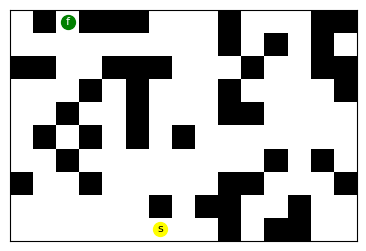

In [38]:
percent_blockage = 0.25

graph = Graph(rows=10, cols=15)
graph.generate_grid(grid_type="random", percent_blocked=percent_blockage)

plot_grid(graph.p_start, graph.p_end, graph.grid)
plt.show()

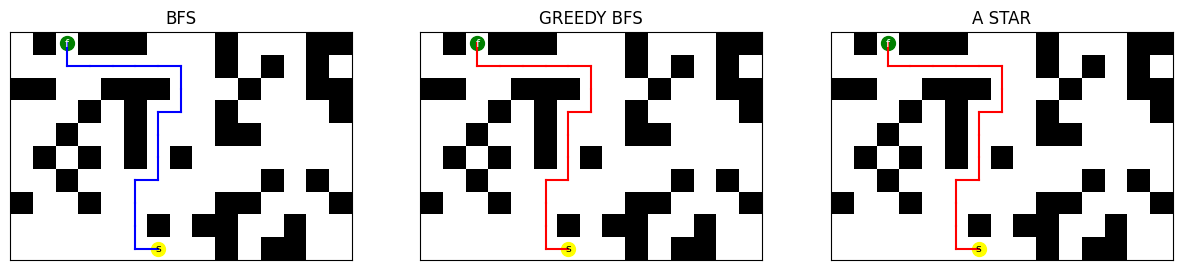

BFS:
Time: 0.00028634071350097656 (s)
# Iteractions: 98
Path length: 17

GREEDY BFS:
Time: 9.894371032714844e-05 (s)
# Iteractions: 27
Path length: 17

A STAR:
Time: 0.00016498565673828125 (s)
# Iteractions: 45
Path length: 17


In [39]:
bfs_path, bfs_complexity = graph.search(bfs)
greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
astar_path, astar_complexity = graph.search(a_star)

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='red',label='GREEDY BFS')
plot_path(axes[2], astar_path, c='red',label='A STAR')

plt.show()

print("BFS:")
print("Time:", bfs_complexity["time"], "(s)")
print("# Iteractions:", bfs_complexity["iterations"])
print("Path length:", bfs_complexity["length"])

print()
print("GREEDY BFS:")
print("Time:", greedy_bfs_complexity["time"], "(s)")
print("# Iteractions:", greedy_bfs_complexity["iterations"])
print("Path length:", greedy_bfs_complexity["length"])

print()
print("A STAR:")
print("Time:", astar_complexity["time"], "(s)")
print("# Iteractions:", astar_complexity["iterations"])
print("Path length:", astar_complexity["length"])

### Let's see it in action

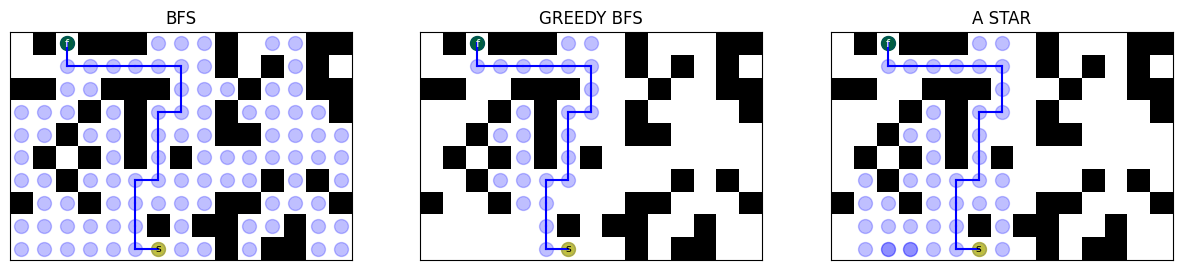

In [40]:
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("BFS")
    axes[1].set_title("GREEDY BFS")
    axes[2].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

clear_output(wait=True)
plt.close()

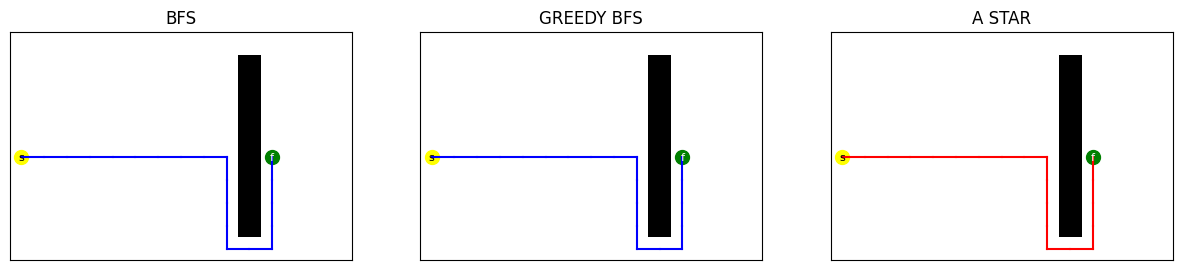

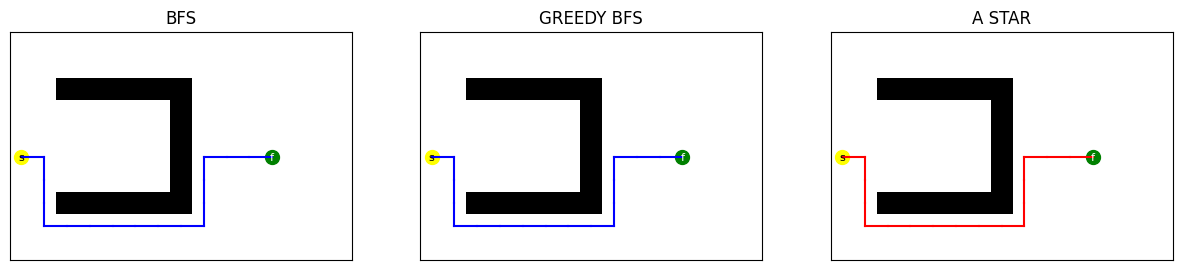

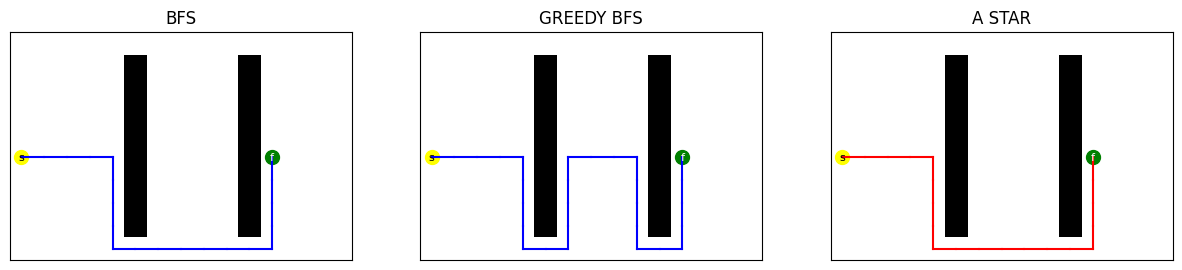

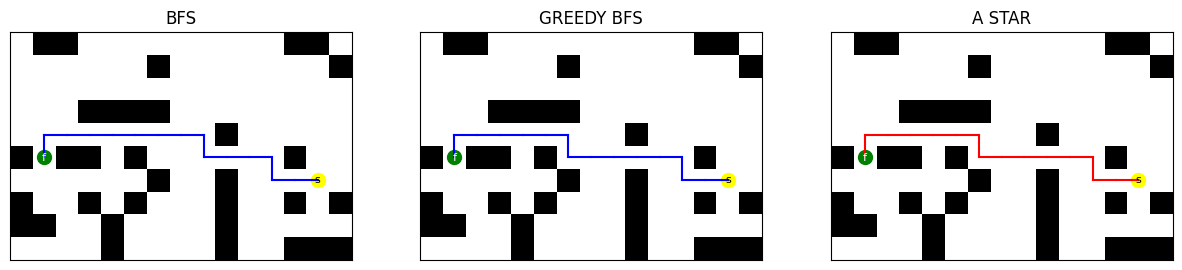

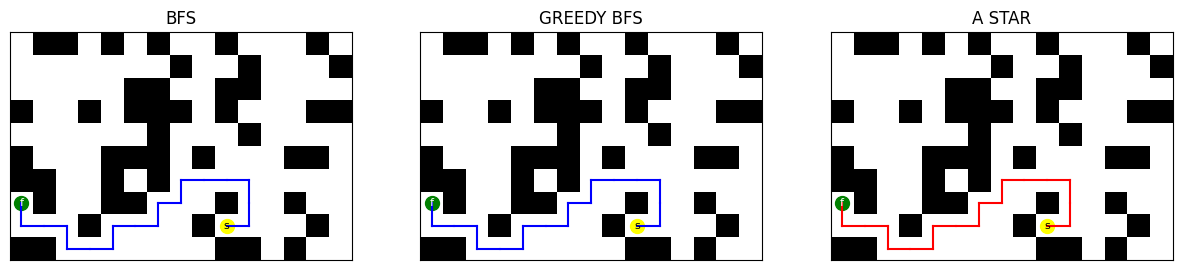

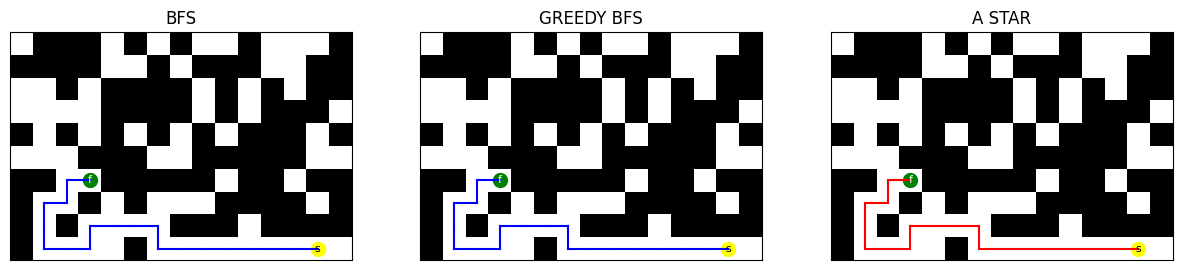

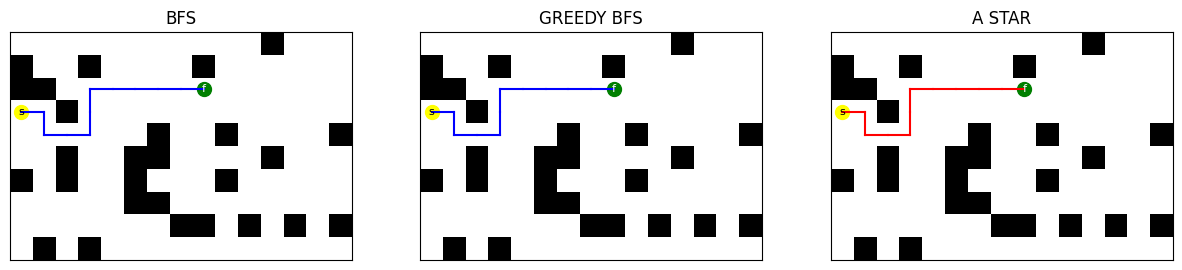

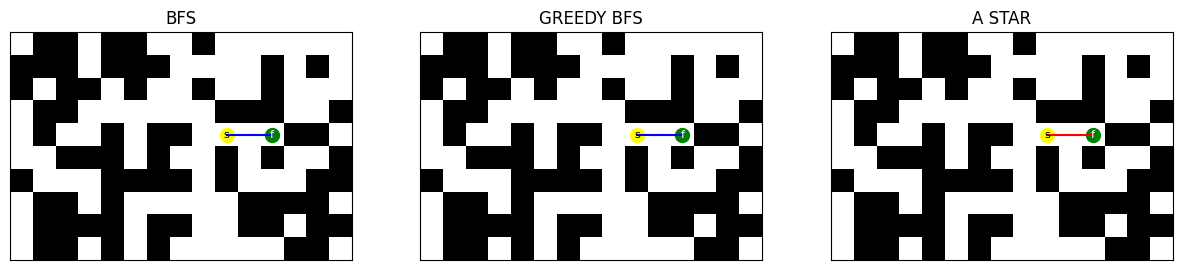

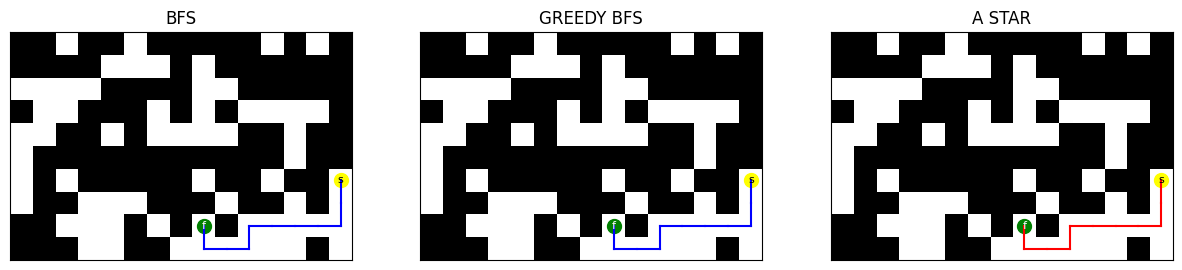

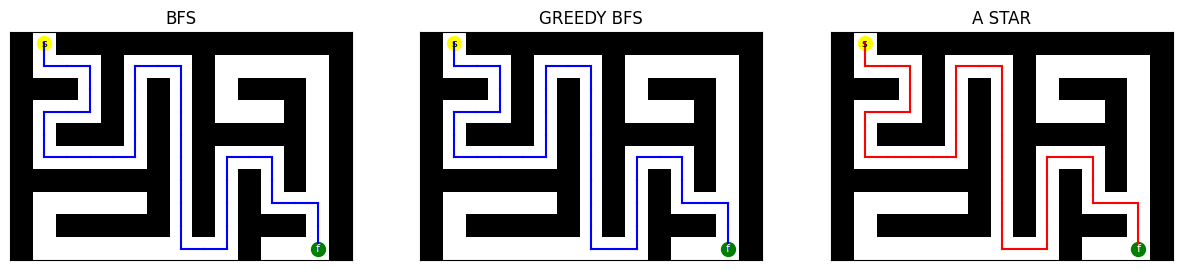

In [42]:
n = 1_000

datas = []
percent_blockages = [0.2, 0.4, 0.6]

graph = Graph(rows=10, cols=15)

for variant in [0,1,2]:
    data = {
        "percent": 0,
        "type": "fixed_" + str(variant),
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "a_star": {"time": 0, "iterations": 0, "length": 0},
    }
    graph.generate_grid(grid_type="fixed", variant=variant)

    bfs_path, bfs_complexity = graph.search(bfs)
    greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
    astar_path, astar_complexity = graph.search(a_star)

    data["bfs"]["time"] = bfs_complexity["time"]
    data["bfs"]["iterations"] = bfs_complexity["iterations"]
    data["bfs"]["length"] = bfs_complexity["length"]

    data["greedy_bfs"]["time"] = greedy_bfs_complexity["time"]
    data["greedy_bfs"]["iterations"] = greedy_bfs_complexity["iterations"]
    data["greedy_bfs"]["length"] = greedy_bfs_complexity["length"]

    data["a_star"]["time"] = astar_complexity["time"]
    data["a_star"]["iterations"] = astar_complexity["iterations"]
    data["a_star"]["length"] = astar_complexity["length"]

    _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], bfs_path, c='blue',label='BFS')
    plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
    plot_path(axes[2], astar_path, c='red',label='A STAR')

    plt.show()

    datas.append(data)

# Random grids with varying percent blockages
for grid_type in ["random", "random-1"]:
    for percent in percent_blockages:
        data = {
            "percent": percent,
            "type": "random",
            "bfs": {"time": 0, "iterations": 0, "length": 0},
            "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
            "a_star": {"time": 0, "iterations": 0, "length": 0},
        }
        for i in range(n):
            graph.generate_grid(grid_type="random", percent_blocked=percent)

            bfs_path, bfs_complexity = graph.search(bfs)
            greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
            astar_path, astar_complexity = graph.search(a_star)

            data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
            data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
            data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

            data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
            data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
            data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

            data["a_star"]["time"] = (data["a_star"]["time"] * i + astar_complexity["time"]) / (i + 1)
            data["a_star"]["iterations"] = (data["a_star"]["iterations"] * i + astar_complexity["iterations"]) / (i + 1)
            data["a_star"]["length"] = (data["a_star"]["length"] * i + astar_complexity["length"]) / (i + 1)


        _, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
        plot_path(axes[0], bfs_path, c='blue',label='BFS')
        plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
        plot_path(axes[2], astar_path, c='red',label='A STAR')

        plt.show()

        datas.append(data)
# Maze grids
data = {
    "percent": 0,
    "type": "maze",
    "bfs": {"time": 0, "iterations": 0, "length": 0},
    "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
    "a_star": {"time": 0, "iterations": 0, "length": 0},
}
for i in range(n):
    graph.generate_grid(grid_type="maze")

    bfs_path, bfs_complexity = graph.search(bfs)
    greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
    astar_path, astar_complexity = graph.search(a_star)

    if bfs_complexity["time"] is None: continue

    data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
    data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
    data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

    data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
    data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
    data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

    data["a_star"]["time"] = (data["a_star"]["time"] * i + astar_complexity["time"]) / (i + 1)
    data["a_star"]["iterations"] = (data["a_star"]["iterations"] * i + astar_complexity["iterations"]) / (i + 1)
    data["a_star"]["length"] = (data["a_star"]["length"] * i + astar_complexity["length"]) / (i + 1)

_, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,3))

plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
plot_path(axes[0], bfs_path, c='blue',label='BFS')
plot_path(axes[1], greedy_bfs_path, c='blue',label='GREEDY BFS')
plot_path(axes[2], astar_path, c='red',label='A STAR')

plt.show()

datas.append(data)


In [43]:
data_df = {"percent": [], "type": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    for k in ["time", "iterations", "length"]:
        for t in ["bfs", "greedy_bfs", "a_star"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [44]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                       iterations             \
                      bfs greedy_bfs    a_star         bfs greedy_bfs   
percent type                                                            
0.0     fixed_0  0.000300   0.000123  0.000261  123.000000  36.000000   
        fixed_1  0.000213   0.000107  0.000109  111.000000  45.000000   
        fixed_2  0.000215   0.000134  0.000159  115.000000  59.000000   
0.2     random   0.000107   0.000032  0.000044   62.132000  12.493000   
0.4     random   0.000072   0.000043  0.000050   41.653000  20.146000   
0.6     random   0.000043   0.000037  0.000039   24.844000  19.138000   
0.2     random   0.000106   0.000032  0.000043   61.983000  12.317000   
0.4     random   0.000073   0.000043  0.000051   42.577000  20.322000   
0.6     random   0.000045   0.000039  0.000041   26.046000  19.941000   
0.0     maze     0.000083   0.000073  0.000080   49.206292  39.906203   

                               length                        
                    a_star        bfs greedy_bfs     a_star  
percent type                                                 
0.0     fixed_0  96.000000  19.000000  19.000000  19.000000  
        fixed_1  47.000000  17.000000  17.000000  17.000000  
        fixed_2  72.000000  19.000000  27.000000  19.000000  
0.2     random   18.151000   9.574000  10.078000   9.574000  
0.4     random   23.940000  13.146000  13.434000  13.146000  
0.6     random   19.985000  14.203000  14.261000  14.203000  
0.2     random   17.857000   9.450000   9.952000   9.450000  
0.4     random   24.620000  13.466000  13.784000  13.466000  
0.6     random   20.970000  14.928000  14.980000  14.928000  
0.0     maze     43.077742  36.673774  36.673774  36.673774

# Exhaustive Search

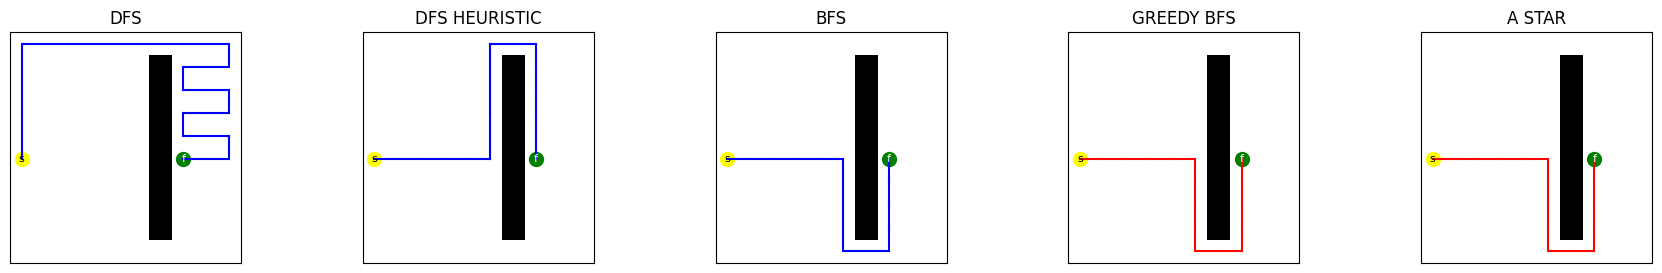

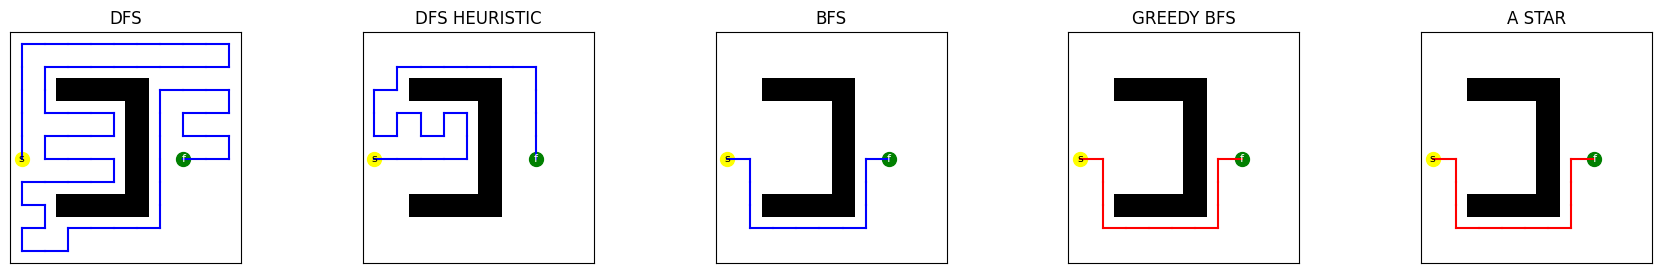

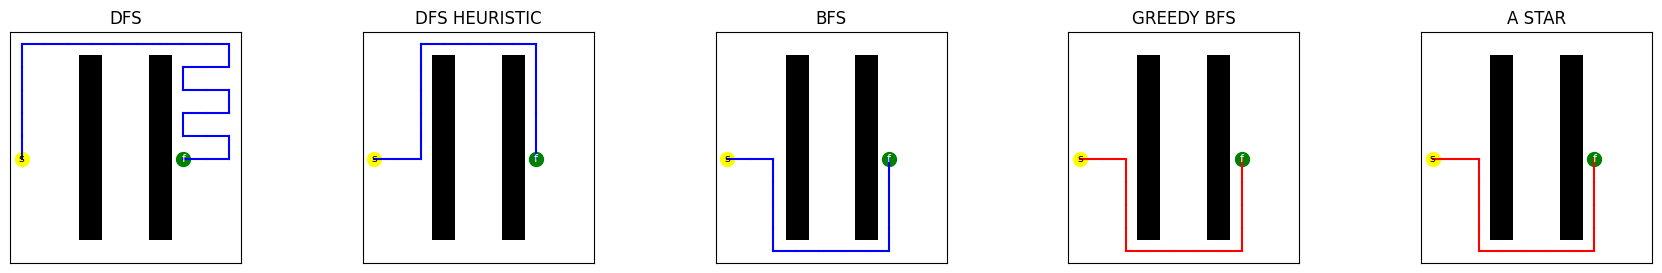

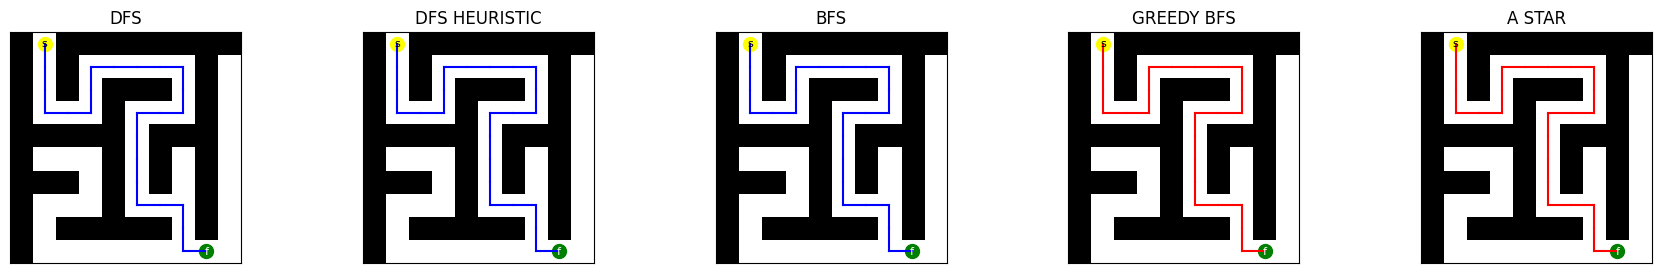

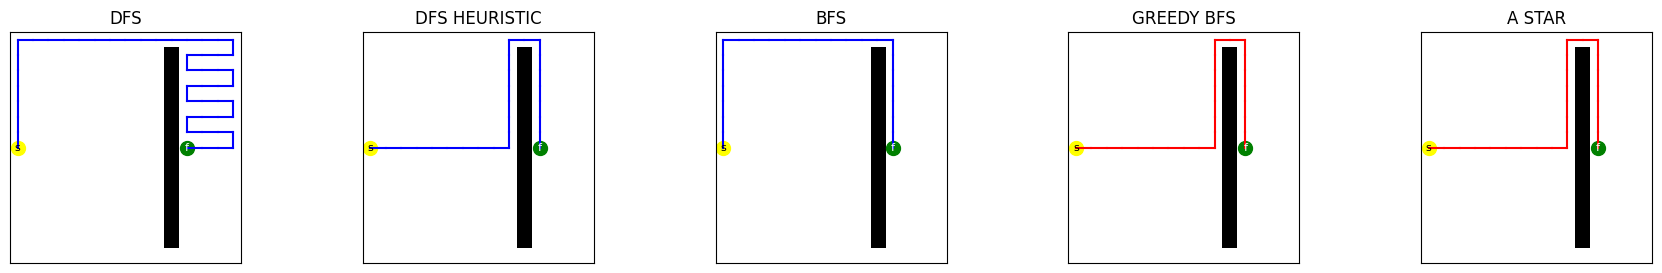

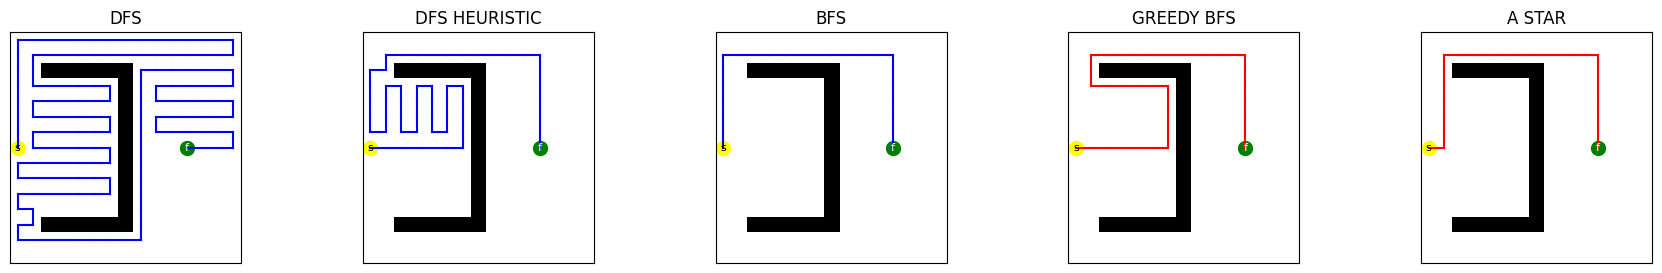

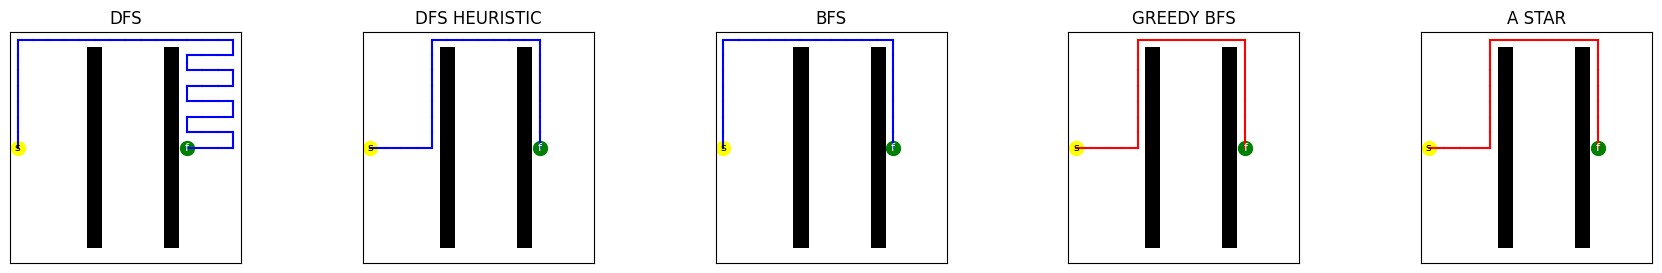

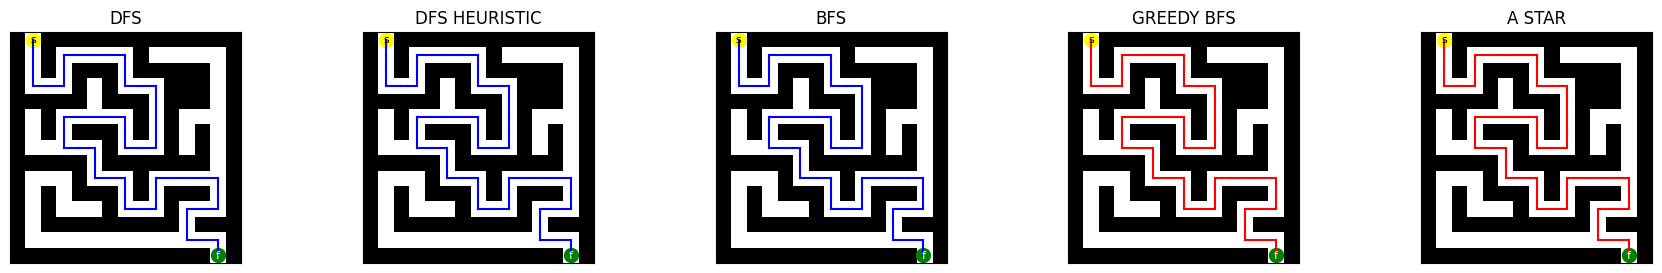

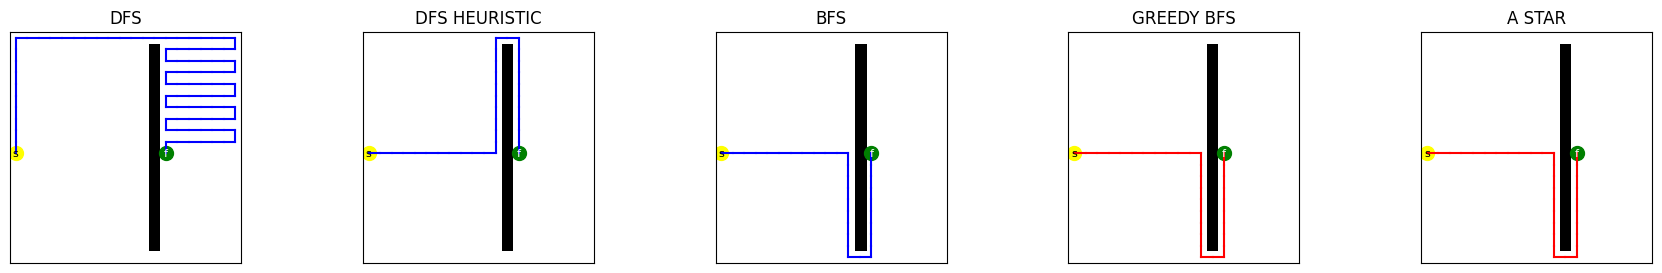

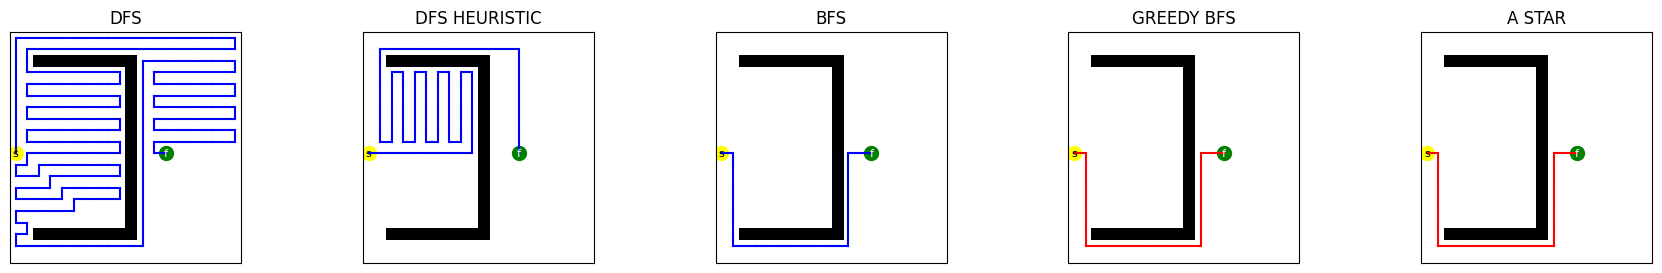

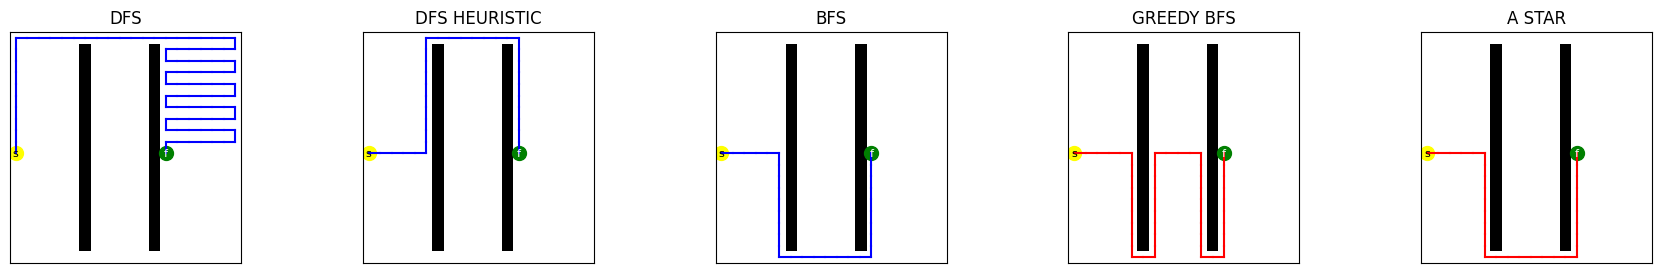

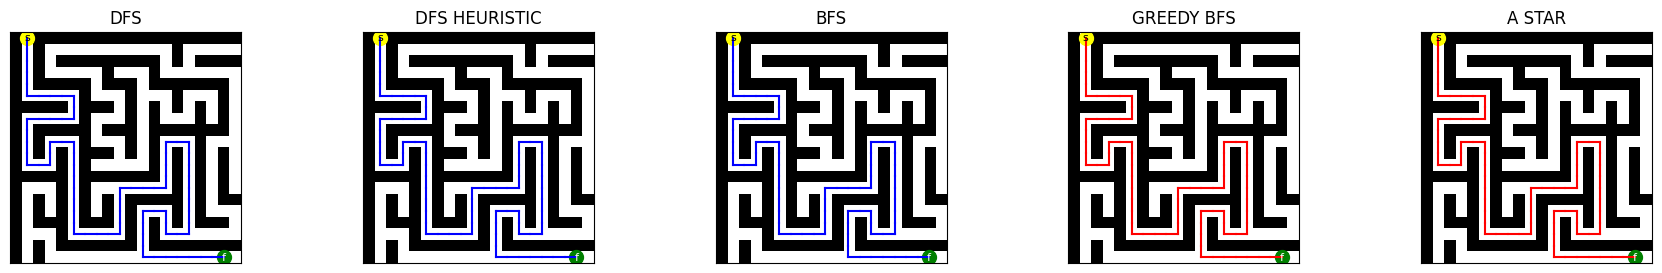

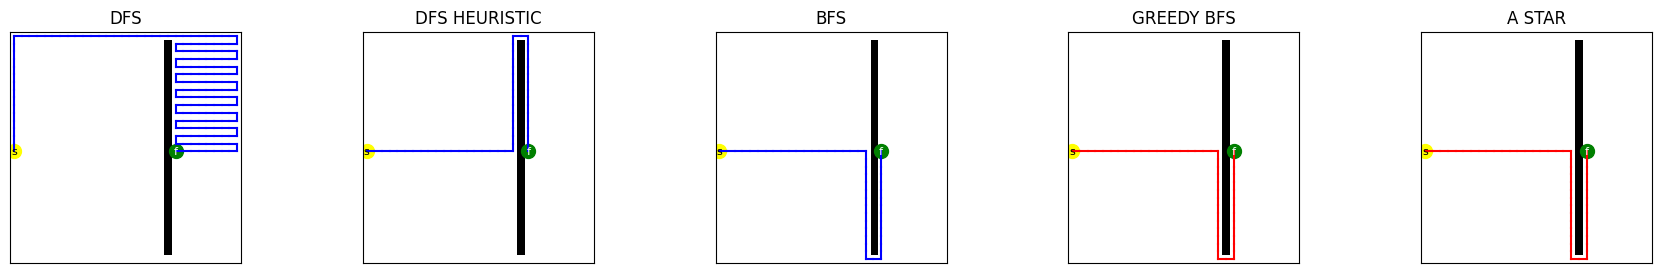

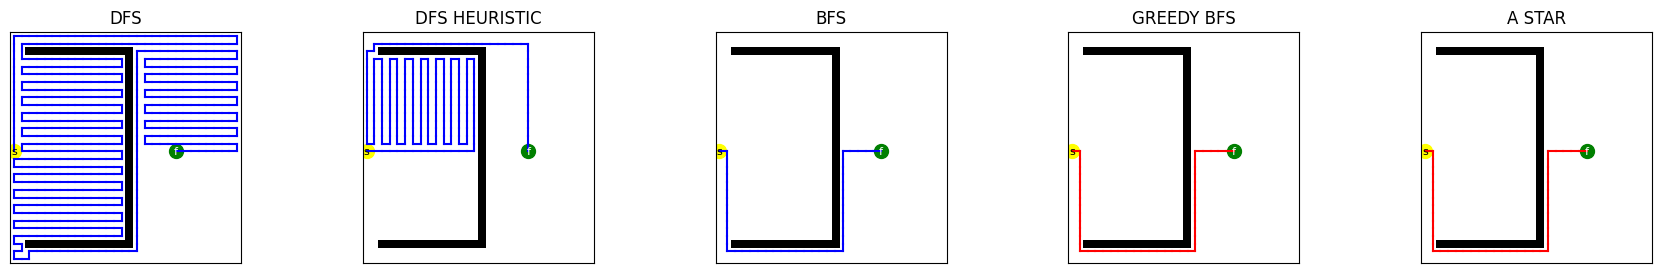

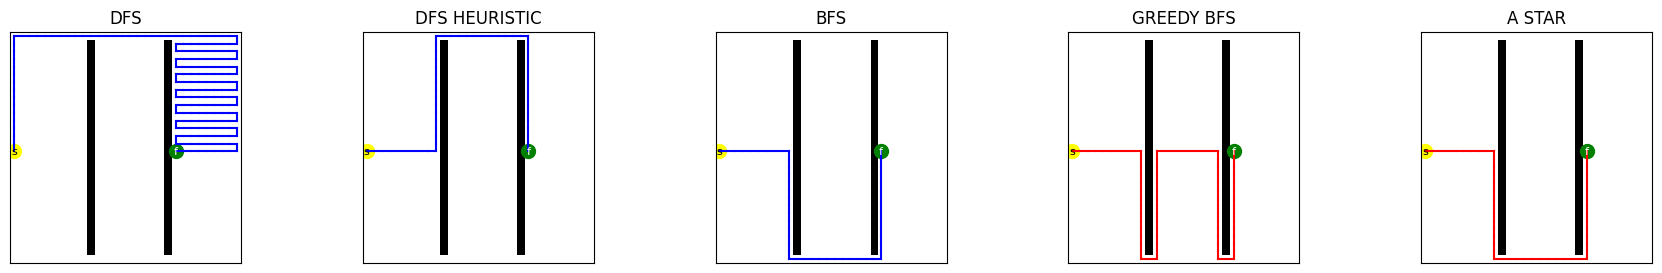

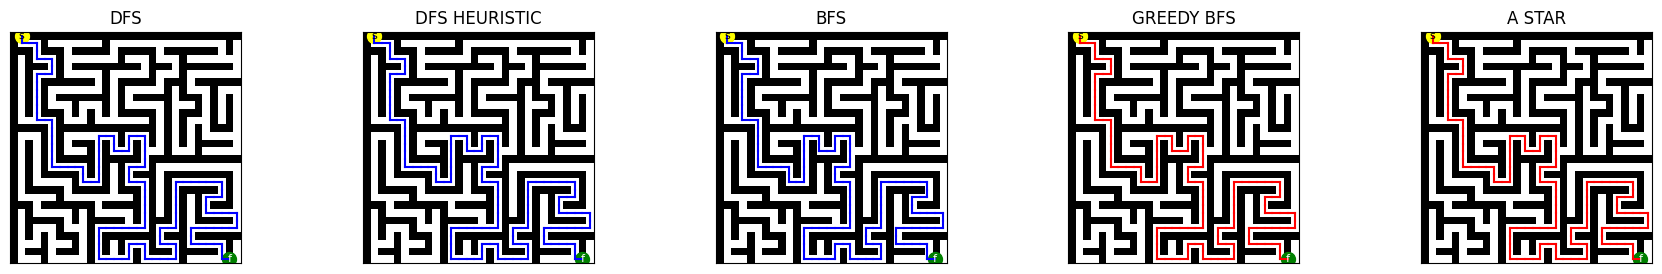

In [46]:
n = 500

datas = []

dimensions = [(10,10), (15,15), (20,20), (30,30)]
percent_blockages = [0.2, 0.4, 0.6]

for (rows, cols) in dimensions:
    
    graph = Graph(rows=rows, cols=cols)

    for variant in [0,1,2]:
        data = {
            "percent": 0,
            "dimension": (rows, cols),
            "type": "fixed_" + str(variant),
            "dfs": {"time": 0, "iterations": 0, "length": 0},
            "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
            "bfs": {"time": 0, "iterations": 0, "length": 0},
            "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
            "a_star": {"time": 0, "iterations": 0, "length": 0},
        }
        graph.generate_grid(grid_type="fixed", variant=variant)

        dfs_path, dfs_complexity = graph.search(dfs)
        dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)
        bfs_path, bfs_complexity = graph.search(bfs)
        greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
        astar_path, astar_complexity = graph.search(a_star)

        data["dfs"]["time"] = dfs_complexity["time"]
        data["dfs"]["iterations"] = dfs_complexity["iterations"]
        data["dfs"]["length"] = dfs_complexity["length"]

        data["dfs_heur"]["time"] = dfs_heur_complexity["time"]
        data["dfs_heur"]["iterations"] = dfs_heur_complexity["iterations"]
        data["dfs_heur"]["length"] = dfs_heur_complexity["length"]

        data["bfs"]["time"] = bfs_complexity["time"]
        data["bfs"]["iterations"] = bfs_complexity["iterations"]
        data["bfs"]["length"] = bfs_complexity["length"]

        data["greedy_bfs"]["time"] = greedy_bfs_complexity["time"]
        data["greedy_bfs"]["iterations"] = greedy_bfs_complexity["iterations"]
        data["greedy_bfs"]["length"] = greedy_bfs_complexity["length"]

        data["a_star"]["time"] = astar_complexity["time"]
        data["a_star"]["iterations"] = astar_complexity["iterations"]
        data["a_star"]["length"] = astar_complexity["length"]


        _, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))

        plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
        plot_path(axes[0], dfs_path, c='blue',label='DFS')
        plot_path(axes[1], dfs_heur_path, c='blue',label='DFS HEURISTIC')
        plot_path(axes[2], bfs_path, c='blue',label='BFS')
        plot_path(axes[3], greedy_bfs_path, c='red',label='GREEDY BFS')
        plot_path(axes[4], astar_path, c='red',label='A STAR')

        plt.show()

        datas.append(data)

    # Random grids with varying percent blockages
    for grid_type in ["random", "random-1"]:
        for percent in percent_blockages:
            data = {
                "percent": percent,
                "dimension": (rows, cols),
                "type": "random",
                "dfs": {"time": 0, "iterations": 0, "length": 0},
                "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
                "bfs": {"time": 0, "iterations": 0, "length": 0},
                "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
                "a_star": {"time": 0, "iterations": 0, "length": 0},
            }
            for i in range(n):
                graph.generate_grid(grid_type="random", percent_blocked=percent)

                dfs_path, dfs_complexity = graph.search(dfs)
                dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)
                bfs_path, bfs_complexity = graph.search(bfs)
                greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
                astar_path, astar_complexity = graph.search(a_star)

                data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
                data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
                data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)

                data["dfs_heur"]["time"] = (data["dfs_heur"]["time"] * i + dfs_heur_complexity["time"]) / (i + 1)
                data["dfs_heur"]["iterations"] = (data["dfs_heur"]["iterations"] * i + dfs_heur_complexity["iterations"]) / (i + 1)
                data["dfs_heur"]["length"] = (data["dfs_heur"]["length"] * i + dfs_heur_complexity["length"]) / (i + 1)

                data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
                data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
                data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

                data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
                data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
                data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

                data["a_star"]["time"] = (data["a_star"]["time"] * i + astar_complexity["time"]) / (i + 1)
                data["a_star"]["iterations"] = (data["a_star"]["iterations"] * i + astar_complexity["iterations"]) / (i + 1)
                data["a_star"]["length"] = (data["a_star"]["length"] * i + astar_complexity["length"]) / (i + 1)

            if percent == 0.3:
                _, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))

                plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
                plot_path(axes[0], dfs_path, c='blue',label='DFS')
                plot_path(axes[1], dfs_heur_path, c='blue',label='DFS HEURISTIC')
                plot_path(axes[2], bfs_path, c='blue',label='BFS')
                plot_path(axes[3], greedy_bfs_path, c='red',label='GREEDY BFS')
                plot_path(axes[4], astar_path, c='red',label='A STAR')

                plt.show()

            datas.append(data)
    # Maze grids
    data = {
        "percent": 0,
        "dimension": (rows, cols),
        "type": "maze",
        "dfs": {"time": 0, "iterations": 0, "length": 0},
        "dfs_heur": {"time": 0, "iterations": 0, "length": 0},
        "bfs": {"time": 0, "iterations": 0, "length": 0},
        "greedy_bfs": {"time": 0, "iterations": 0, "length": 0},
        "a_star": {"time": 0, "iterations": 0, "length": 0},
    }
    for i in range(n):
        graph.generate_grid(grid_type="maze")

        dfs_path, dfs_complexity = graph.search(dfs)
        dfs_heur_path, dfs_heur_complexity = graph.search(dfs_heuristic)
        bfs_path, bfs_complexity = graph.search(bfs)
        greedy_bfs_path, greedy_bfs_complexity = graph.search(greedy_bfs)
        astar_path, astar_complexity = graph.search(a_star)

        if bfs_complexity["time"] is None: continue

        data["dfs"]["time"] = (data["dfs"]["time"] * i + dfs_complexity["time"]) / (i + 1)
        data["dfs"]["iterations"] = (data["dfs"]["iterations"] * i + dfs_complexity["iterations"]) / (i + 1)
        data["dfs"]["length"] = (data["dfs"]["length"] * i + dfs_complexity["length"]) / (i + 1)

        data["dfs_heur"]["time"] = (data["dfs_heur"]["time"] * i + dfs_heur_complexity["time"]) / (i + 1)
        data["dfs_heur"]["iterations"] = (data["dfs_heur"]["iterations"] * i + dfs_heur_complexity["iterations"]) / (i + 1)
        data["dfs_heur"]["length"] = (data["dfs_heur"]["length"] * i + dfs_heur_complexity["length"]) / (i + 1)

        data["bfs"]["time"] = (data["bfs"]["time"] * i + bfs_complexity["time"]) / (i + 1)
        data["bfs"]["iterations"] = (data["bfs"]["iterations"] * i + bfs_complexity["iterations"]) / (i + 1)
        data["bfs"]["length"] = (data["bfs"]["length"] * i + bfs_complexity["length"]) / (i + 1)

        data["greedy_bfs"]["time"] = (data["greedy_bfs"]["time"] * i + greedy_bfs_complexity["time"]) / (i + 1)
        data["greedy_bfs"]["iterations"] = (data["greedy_bfs"]["iterations"] * i + greedy_bfs_complexity["iterations"]) / (i + 1)
        data["greedy_bfs"]["length"] = (data["greedy_bfs"]["length"] * i + greedy_bfs_complexity["length"]) / (i + 1)

        data["a_star"]["time"] = (data["a_star"]["time"] * i + astar_complexity["time"]) / (i + 1)
        data["a_star"]["iterations"] = (data["a_star"]["iterations"] * i + astar_complexity["iterations"]) / (i + 1)
        data["a_star"]["length"] = (data["a_star"]["length"] * i + astar_complexity["length"]) / (i + 1)
    
    _, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))

    plot_grid(graph.p_start, graph.p_end, graph.grid, axes)
    plot_path(axes[0], dfs_path, c='blue',label='DFS')
    plot_path(axes[1], dfs_heur_path, c='blue',label='DFS HEURISTIC')
    plot_path(axes[2], bfs_path, c='blue',label='BFS')
    plot_path(axes[3], greedy_bfs_path, c='red',label='GREEDY BFS')
    plot_path(axes[4], astar_path, c='red',label='A STAR')

    plt.show()

    datas.append(data)




In [47]:
data_df = {"percent": [], "type": [], "dimension": []}
for d in datas:
    data_df["percent"].append(d["percent"])
    data_df["type"].append(d["type"])
    data_df["dimension"].append(d["dimension"])
    for k in ["time", "iterations", "length"]:
        for t in ["dfs", "dfs_heur", "bfs", "greedy_bfs", "a_star"]:
            if (k,t) not in data_df:
                data_df[(k,t)] = []
            data_df[(k,t)].append(d[t][k])

In [48]:
df = pd.DataFrame.from_dict(data_df)
df = df.set_index(['percent', 'type', 'dimension'])
df.columns = pd.MultiIndex.from_tuples(df.columns)


df

time                                           \
                                dfs  dfs_heur       bfs greedy_bfs    a_star   
percent type    dimension                                                      
0.0     fixed_0 (10, 10)   0.000055  0.000044  0.000158   0.000083  0.000135   
        fixed_1 (10, 10)   0.000099  0.000061  0.000143   0.000079  0.000082   
        fixed_2 (10, 10)   0.000049  0.000041  0.000134   0.000103  0.000097   
0.2     random  (10, 10)   0.000058  0.000027  0.000082   0.000028  0.000035   
0.4     random  (10, 10)   0.000041  0.000037  0.000052   0.000032  0.000037   
0.6     random  (10, 10)   0.000025  0.000032  0.000037   0.000032  0.000033   
0.2     random  (10, 10)   0.000056  0.000025  0.000074   0.000026  0.000033   
0.4     random  (10, 10)   0.000041  0.000035  0.000051   0.000031  0.000035   
0.6     random  (10, 10)   0.000025  0.000031  0.000036   0.000031  0.000033   
0.0     maze    (10, 10)   0.000057  0.000051  0.000055   0.000050  0.000053   
        fixed_0 (15, 15)   0.000071  0.000055  0.000350   0.000146  0.000316   
        fixed_1 (15, 15)   0.000197  0.000113  0.000345   0.000184  0.000225   
        fixed_2 (15, 15)   0.000075  0.000057  0.000331   0.000138  0.000240   
0.2     random  (15, 15)   0.000112  0.000044  0.000146   0.000036  0.000051   
0.4     random  (15, 15)   0.000085  0.000073  0.000099   0.000057  0.000069   
0.6     random  (15, 15)   0.000041  0.000053  0.000058   0.000050  0.000054   
0.2     random  (15, 15)   0.000113  0.000040  0.000146   0.000036  0.000053   
0.4     random  (15, 15)   0.000090  0.000075  0.000102   0.000059  0.000071   
0.6     random  (15, 15)   0.000043  0.000055  0.000061   0.000052  0.000055   
0.0     maze    (15, 15)   0.000152  0.000095  0.000113   0.000097  0.000106   
        fixed_0 (20, 20)   0.000128  0.000071  0.000590   0.000250  0.000504   
        fixed_1 (20, 20)   0.000348  0.000202  0.000564   0.000340  0.000354   
        fixed_2 (20, 20)   0.000127  0.000070  0.000541   0.000362  0.000389   
0.2     random  (20, 20)   0.000211  0.000056  0.000265   0.000049  0.000082   
0.4     random  (20, 20)   0.000155  0.000131  0.000168   0.000091  0.000118   
0.6     random  (20, 20)   0.000060  0.000078  0.000084   0.000073  0.000079   
0.2     random  (20, 20)   0.000211  0.000060  0.000273   0.000049  0.000084   
0.4     random  (20, 20)   0.000148  0.000138  0.000170   0.000091  0.000120   
0.6     random  (20, 20)   0.000056  0.000076  0.000082   0.000071  0.000077   
0.0     maze    (20, 20)   0.000249  0.000167  0.000195   0.000164  0.000192   
        fixed_0 (30, 30)   0.000212  0.000104  0.001442   0.000514  0.001248   
        fixed_1 (30, 30)   0.000737  0.000514  0.001332   0.000798  0.000857   
        fixed_2 (30, 30)   0.000218  0.000101  0.001265   0.000841  0.001000   
0.2     random  (30, 30)   0.000432  0.000109  0.000559   0.000069  0.000134   
0.4     random  (30, 30)   0.000347  0.000304  0.000349   0.000170  0.000248   
0.6     random  (30, 30)   0.000090  0.000124  0.000131   0.000116  0.000126   
0.2     random  (30, 30)   0.000466  0.000102  0.000580   0.000072  0.000151   
0.4     random  (30, 30)   0.000343  0.000305  0.000362   0.000182  0.000255   
0.6     random  (30, 30)   0.000090  0.000126  0.000133   0.000117  0.000128   
0.0     maze    (30, 30)   0.000597  0.000381  0.000436   0.000351  0.000443   

                           iterations                                      \
                                  dfs    dfs_heur         bfs  greedy_bfs   
percent type    dimension                                                   
0.0     fixed_0 (10, 10)    30.000000   18.000000   81.000000   32.000000   
        fixed_1 (10, 10)    72.000000   28.000000   75.000000   33.000000   
        fixed_2 (10, 10)    30.000000   18.000000   73.000000   45.000000   
0.2     random  (10, 10)    53.382000   13.538000   43.588000   10.018000   
0.4     random  (10, 10)    37.936000   20.656000  

## Let's see these in action on the fixed grid variants

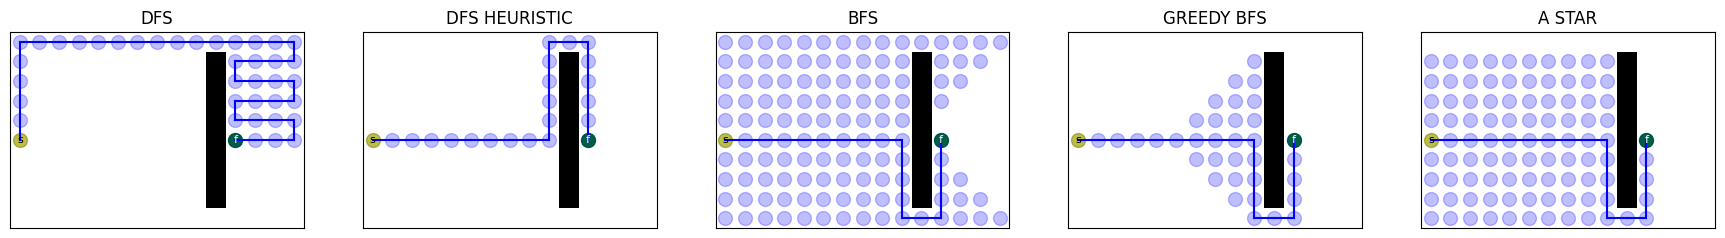

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
dfs
a_star
bfs


In [49]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=0)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

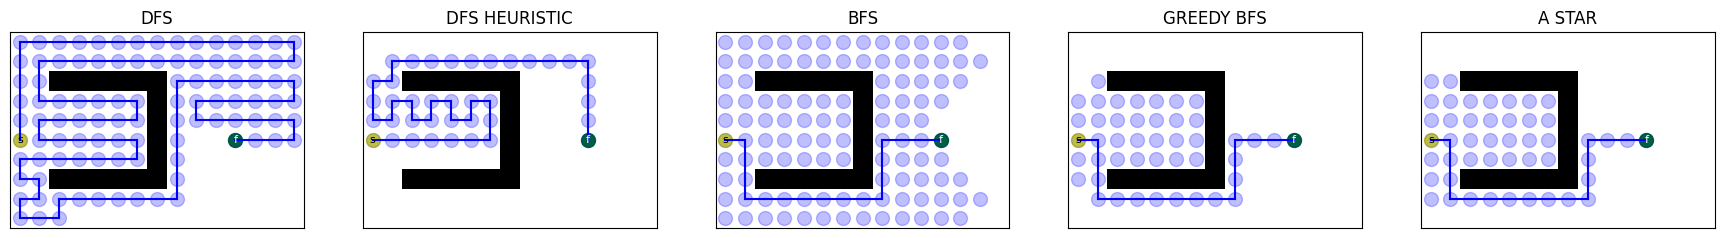

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
dfs
bfs


In [50]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=1)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

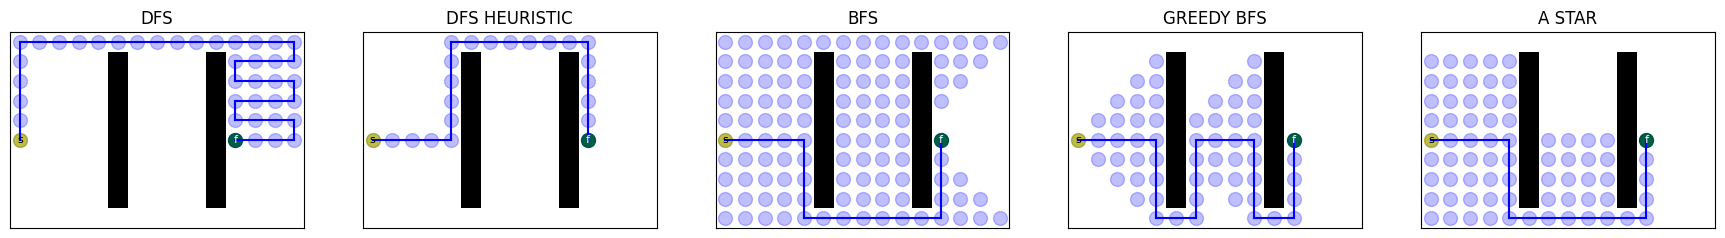

ORDER (fast to slow):
dfs_heuristic
dfs
greedy_bfs
a_star
bfs


In [51]:
graph = Graph(rows=10, cols=15)

graph.generate_grid(grid_type="fixed", variant=2)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []

exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

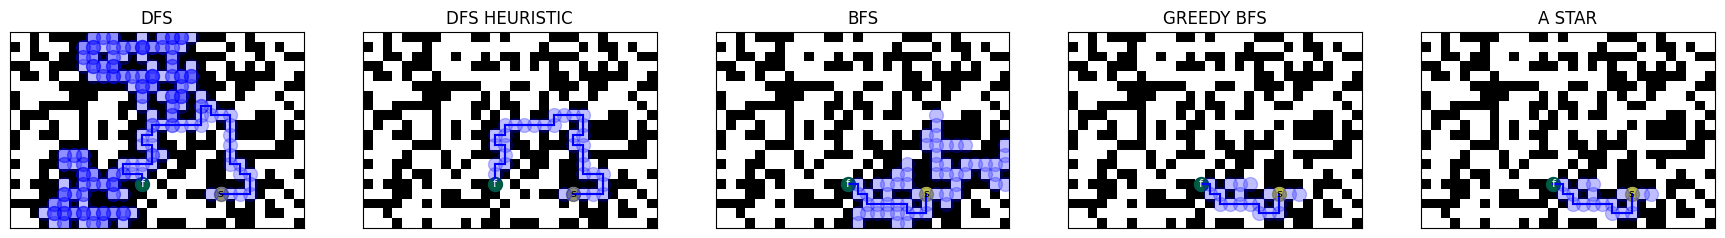

ORDER (fast to slow):
a_star
greedy_bfs
dfs_heuristic
bfs
dfs


In [52]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random", percent_blocked=0.4)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

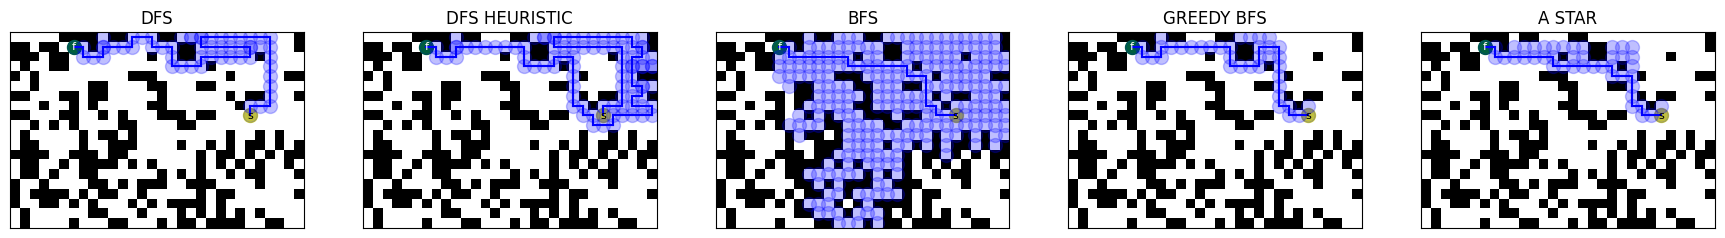

ORDER (fast to slow):
greedy_bfs
a_star
dfs
dfs_heuristic
bfs


In [53]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="random-1", percent_blocked=0.4)

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()

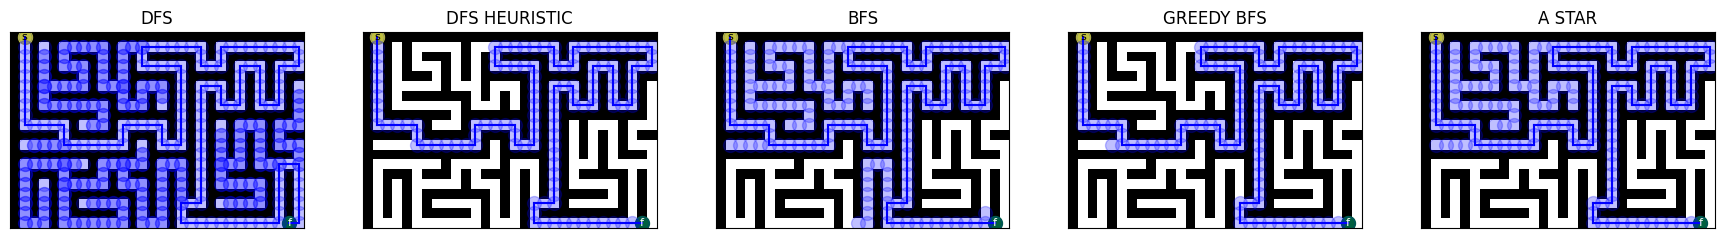

ORDER (fast to slow):
dfs_heuristic
greedy_bfs
a_star
bfs
dfs


In [54]:
graph = Graph(rows=20, cols=30)

graph.generate_grid(grid_type="maze")

dfs_generator = graph.search_generator(dfs)
dfs_heur_generator = graph.search_generator(dfs_heuristic)
bfs_generator = graph.search_generator(bfs)
greedy_bfs_generator = graph.search_generator(greedy_bfs)
astar_generator = graph.search_generator(a_star)

generators = [dfs_generator, dfs_heur_generator, bfs_generator, greedy_bfs_generator, astar_generator]

_, axes = plt.subplots(ncols=5, nrows=1, figsize=(22,3))
plot_grid(graph.p_start, graph.p_end, graph.grid, axes)

# Using this so we don't redraw every single point, but we update the scatter array.
# We see drastic speedups when doing this.
scatters = []
x_coords = [[] for _ in range(5)]
y_coords = [[] for _ in range(5)]
for i in range(len(generators)):
    scatter = axes[i].scatter(x_coords[i], y_coords[i], s=100, c="blue", alpha=.25)
    scatters.append(scatter)

winners = []
    
exists = True
while exists:
    exists_i = False
    for i, generator in enumerate(generators):

        type_, node = next(generator, (None, None))
        if type_ == "search":
            x_coords[i].append(node[1])
            y_coords[i].append(node[0])
            # Update data of scatter plot
            scatters[i].set_offsets(list(zip(x_coords[i], y_coords[i])))
        elif type_ == "path":
            winners.append(generator.__name__)
            plot_path(axes[i], node, c='blue')
        
        exists_i = exists_i or (type_ is not None)
    clear_output(wait=True)

    axes[0].set_title("DFS")
    axes[1].set_title("DFS HEURISTIC")
    axes[2].set_title("BFS")
    axes[3].set_title("GREEDY BFS")
    axes[4].set_title("A STAR")

    display(plt.gcf())
    
    exists = exists_i

print("ORDER (fast to slow):")
print(*winners, sep="\n")

clear_output(wait=True)
plt.close()